# Twitter Sentiment Analysis on Apple and Google Products


### Executive Summary

This project applies machine learning to classify Twitter posts by sentiment, helping businesses quickly understand public perception of their products. Using natural language processing (NLP) techniques and multiple models, including an optimized stacking classifier with Logistic Regression, Naive Bayes, XGBoost, and SVM, the solution achieved strong performance in multi-class sentiment prediction. The final model provides a scalable, automated way to monitor customer feedback in real time and support data-driven decision making.

---
### Business Understanding

For any business, understanding public sentiment about its products is crucial. Social media, especially Twitter, provides a rich source of such opinions, but manually analyzing thousands of tweets is time-consuming and impractical. Negative sentiment, if left unaddressed, can damage a company’s reputation and reduce sales, while positive sentiment presents opportunities to strengthen customer loyalty.

To address this, we use a machine learning model that predicts whether tweets about Google and Apple products express positive or negative sentiment. The dataset, sourced from CrowdFlower, contains tweet text, brand mentions, and sentiment labels. By automating sentiment classification, companies can quickly evaluate product perception, identify areas for improvement, and make informed investment decisions.

The main challenges in this project include collecting and cleaning noisy textual data. These are addressed through the CrowdFlower dataset and preprocessing tools like NLTK and regex. Model training is performed using scikit-learn, enabling accurate and scalable sentiment predictions.

Building such a model requires access to raw social media text, sufficient computational power, a well-labeled dataset for validation, and skilled data scientists to design and train the model.

---
### Problem Statement

Companies like Google and Apple receive thousands of mentions on Twitter daily. Manually tracking these tweets to gauge customer sentiment is time-consuming and impractical. Without an automated approach, businesses risk missing early signs of dissatisfaction or opportunities to leverage positive sentiment. This project addresses this problem by building a machine learning model that classifies tweets about Google and Apple products into sentiment categories (positive, negative, neutral), enabling faster and data-driven decision making.

---
###  Data Understanding

The dataset used in this project was sourced from **CrowdFlower**, and it contains labeled tweets mentioning Google and Apple. Each record has three key components:

1. **Tweet text** – The raw tweet content.

2. **Product reference** – Whether the tweet refers to Google or Apple.

3. **Sentiment label** – Whether the sentiment is positive or negative.

Before building any models, we analyzed the dataset to better understand its structure and quality:

- **Label distribution:** The target column indicates whether a tweet expresses positive or negative sentiment. Understanding the balance between these classes helps in assessing potential bias in model training.

- **Missing values:** A small number of tweets had missing or incomplete content, and these were removed during preprocessing to ensure clean input.

- **Text characteristics:** The tweets are short, informal, and noisy. They include emojis, hashtags, mentions, URLs, slang, repeated characters, and abbreviations. This confirmed the need for thorough preprocessing steps such as cleaning, tokenization, stopword removal, and lemmatization to improve model accuracy.

In summary, the dataset provides a strong foundation for sentiment analysis, but requires careful preparation to handle noise and ensure meaningful model predictions.


In [1]:

# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import html
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import MultinomialNB
!pip install xgboost
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import string
from collections import Counter


%matplotlib inline
import os

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

print("All libraries imported successfully!")
print("Environment setup complete!")




c:\Users\USER\Documents\Moringa\Phase4\Phase4_Project\Phase-4-Project\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
c:\Users\USER\Documents\Moringa\Phase4\Phase4_Project\Phase-4-Project\venv\lib\site-packages\xgboost\compat.py:106: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


All libraries imported successfully!
Environment setup complete!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#reading the data into a dataframe
df = pd.read_csv('judge-1377884607_tweet_product_company.csv',encoding='latin1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [5]:
print((df.isnull().sum()/len(df))*100)

tweet_text                                             0.010997
emotion_in_tweet_is_directed_at                       63.807324
is_there_an_emotion_directed_at_a_brand_or_product     0.000000
dtype: float64


- Replaced null on the 'emotion_in_tweet_is_directed_at' column with 'Unknown' to keep more data for training and testing since it contains 64% of the dataset  
- Dropped for the remaining null values

In [6]:
df['emotion_in_tweet_is_directed_at'] = df['emotion_in_tweet_is_directed_at'].fillna('Unknown')

In [7]:
# Dropping null values for the remaining null values
df = df.dropna()

In [8]:
# Looking at the classes in the target column
df['is_there_an_emotion_directed_at_a_brand_or_product'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

Useful Columns in determining the sentiment of tweets include;

- Tweet_text - is_there_an_emotion_directed_at_a_brand_or_product.

- The middle column which is called 'emotion_in_tweet_is_directed_at' is not useful for our aims. It will not be used in the training of the model.

We created a class named TweetPreprocessor and it will have functions for cleaning the text, Transforming the dataframe and creating a fit for training.

We will use this class within a pipeline. We will have our class inherit from Sklearn's BaseEstimator and TransformerMixin libraries.

BaseEstimator and TransformerMixin make a custom class:

1.Scikit-learn compliant.

2.Fully usable in Pipeline, GridSearchCV and cross_val_score.

---
# Exploratory Data Analysis (EDA)
## Objectives
1. Load data safely
2. Perform data quality checks
3. Summarize numeric & categorical variables
4. Explore outliers, distributions & correlations
5. Export a clean dataset for modeling

In [9]:
!pip install wordcloud

from wordcloud import WordCloud

---
# 1. Dataset Overview

In [10]:
# Remove duplicates
df = df.drop_duplicates()

# Drop rows with empty tweets
df = df.dropna(subset=['tweet_text'])

# Reset index
df.reset_index(drop=True, inplace=True)
# Rename columns 
df.rename(columns=lambda x: x.strip(), inplace=True)



In [11]:
df.to_csv(r"C:cleaned_tweet_dataset_for_modeling.csv", index=False)
print("Cleaned dataset saved.")


Cleaned dataset saved.


In [12]:
df_clean = pd.read_csv(r"C:cleaned_tweet_dataset_for_modeling.csv")


In [13]:

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumns and Data Types:")
print(df.dtypes)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (9070, 3)

Columns and Data Types:
tweet_text                                            object
emotion_in_tweet_is_directed_at                       object
is_there_an_emotion_directed_at_a_brand_or_product    object
dtype: object

First 5 rows:


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [14]:

# 0. Load the cleaned dataset
df_clean = pd.read_csv("cleaned_tweet_dataset_for_modeling.csv")

# 1. Check for missing values
print("Missing values per column:")
print(df_clean.isnull().sum())

# 2. Check the distribution of TARGET variables
print("\n--- Target Variable: Sentiment ---")
sentiment_dist = df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True) * 100
print(sentiment_dist)

print("\n--- Target Variable: Brand ---")
brand_dist = df_clean['emotion_in_tweet_is_directed_at'].value_counts(normalize=True) * 100
print(brand_dist)

# 3. Examine rows with no brand specified
no_brand = df_clean[df_clean['emotion_in_tweet_is_directed_at'].isna()]
print(f"\nNumber of tweets with no brand specified: {len(no_brand)}")
print("Sample of tweets with no brand:")
print(no_brand['tweet_text'].head(3).values)

# 4. Drop rows with no brand for brand classifier
df_for_brand = df_clean.dropna(subset=['emotion_in_tweet_is_directed_at']).copy()
print(f"\nShape of dataset after dropping rows with no brand: {df_for_brand.shape}")

# 5. Simplify Brand Classes
brand_mapping = {
    'iPhone': 'Apple',
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'Other Apple product or service': 'Apple',
    'Google': 'Google',
    'Android': 'Google',
    'Android App': 'Google',
    'Other Google product or service': 'Google'
}
df_for_brand['brand'] = df_for_brand['emotion_in_tweet_is_directed_at'].map(brand_mapping)

print("\n--- Brand Distribution After Mapping ---")
print(df_for_brand['brand'].value_counts(normalize=True) * 100)

# 6. Simplify Sentiment Classes
print("\nSentiment value counts before cleaning:")
print(df_for_brand['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())

df_for_brand = df_for_brand[df_for_brand['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]
print(f"Shape after removing 'I can't tell': {df_for_brand.shape}")

# 7. Create a unified target for multi-class approach
df_for_brand['brand_sentiment'] = df_for_brand['brand'] + '-' + df_for_brand['is_there_an_emotion_directed_at_a_brand_or_product']
print("\n--- Multi-class Label Distribution ---")
print(df_for_brand['brand_sentiment'].value_counts(normalize=True) * 100)


Missing values per column:
tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

--- Target Variable: Sentiment ---
No emotion toward brand or product    59.261301
Positive emotion                      32.745314
Negative emotion                       6.273429
I can't tell                           1.719956
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

--- Target Variable: Brand ---
Unknown                            63.814774
iPad                               10.418964
Apple                               7.265711
iPad or iPhone App                  5.170893
Google                              4.718853
iPhone                              3.263506
Other Google product or service     3.230430
Android App                         0.882029
Android                             0.848953
Other Apple product or service      0.385888
Name: emo

---
 ## Text Preprocessing

Given that our dataset consisted of tweets, the text was informal, noisy, and often inconsistent.  
To prepare it for modeling, we applied a structured cleaning and preprocessing pipeline as follows:

### Text Cleaning  
- *Emoji Removal:* All emojis were stripped out to minimize noise and avoid introducing irrelevant signals.  
- *Hashtag & Mention Removal:* Hashtags and user mentions (e.g., @username) were removed, as they did not add value to sentiment detection.  
- *Link Removal:* URLs and hyperlinks were filtered out to keep only the textual content.  
- *Special Character Filtering:* Non-alphabetic symbols, numbers, and punctuation were removed to standardize the input.  
- *Whitespace Normalization:* Extra spaces were cleaned up for text consistency.  
- *Repeated Letter Reduction:* Overstretched words (e.g., wooooow, heeeello) were normalized to their correct form.

### Tokenization & Stopword Removal  
The cleaned text was then tokenized — split into individual words — and stopwords were removed using our custom stopword list.  
This step ensured that only the most meaningful words remained, improving model focus and reducing noise.

### Testing & Validation  
To verify the correctness of our preprocessing logic, we tested each function on sample tweets.  
This helped confirm that the pipeline was correctly cleaning, filtering, and transforming the data before modeling.


Overall, these steps produced a *clean, standardized, and semantically meaningful text dataset*, making it ready for feature extraction and modeling.








In [15]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_tweet(text):
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|\#', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    
    return ' '.join(filtered_tokens)

# Apply cleaning to a sample of tweets first to test
sample_text = df_clean['tweet_text'].iloc[0]
print("Original text:", sample_text)
print("Cleaned text:", clean_tweet(sample_text))

# Apply cleaning to the entire dataset
df_clean['cleaned_text'] = df_clean['tweet_text'].apply(clean_tweet)

# Check the result
df_clean[['tweet_text', 'cleaned_text']].head()

Original text: .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
Cleaned text: iphone hr tweeting riseaustin dead need upgrade plugin station sxsw


,tweet_text,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iphone hr tweeting riseaustin dead need upgrad...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,hope year festival isnt crashy year iphone app...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri sxsw marissa mayer google tim ...


# Data Analysis

In [16]:


def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # remove mentions & hashtags
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)  # remove punctuation
    text = text.strip()
    return text

# Apply to your dataframe
df_for_brand['cleaned_text'] = df_for_brand['tweet_text'].apply(clean_text)


In [17]:
print(df_for_brand[['tweet_text', 'cleaned_text']].head())


                                          tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

                                        cleaned_text  
0  i have a 3g iphone after 3 hrs tweeting at ris...  
1  know about   awesome ipadiphone app that youll...  
2  can not wait for ipad 2 also they should sale ...  
3  i hope this years festival isnt as crashy as t...  
4  great stuff on fri sxsw marissa mayer google t...  



--- EDA: Visualizations ---


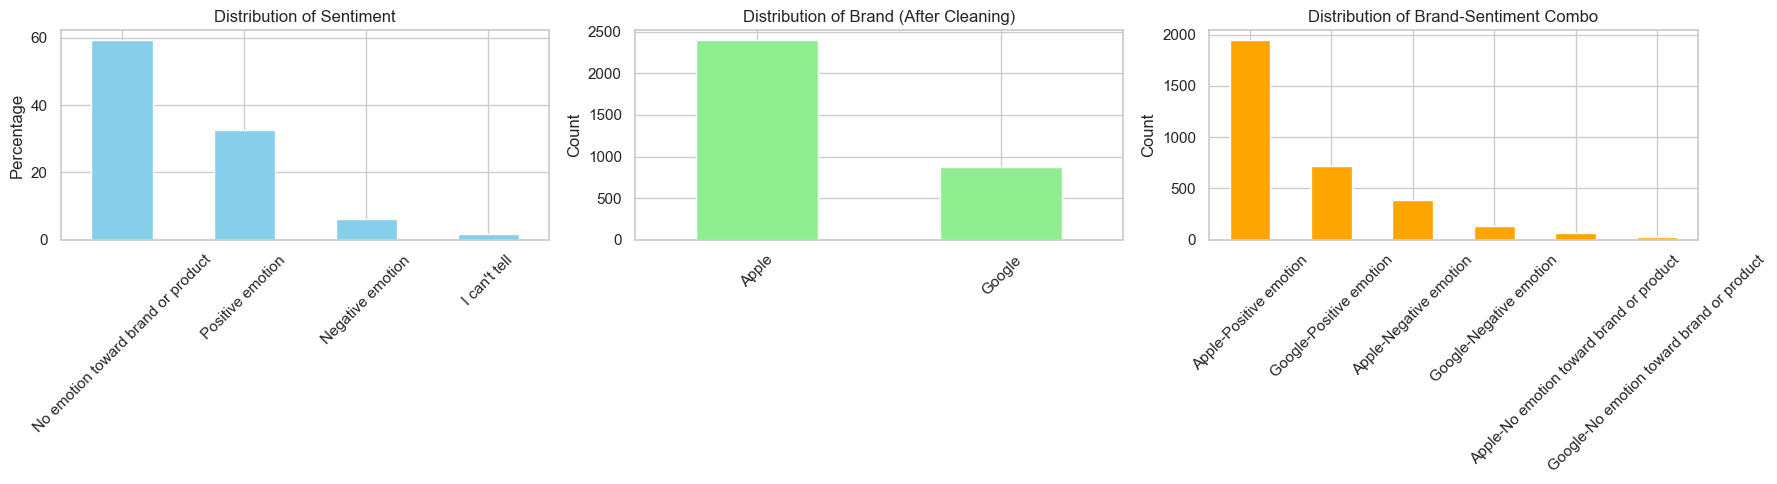

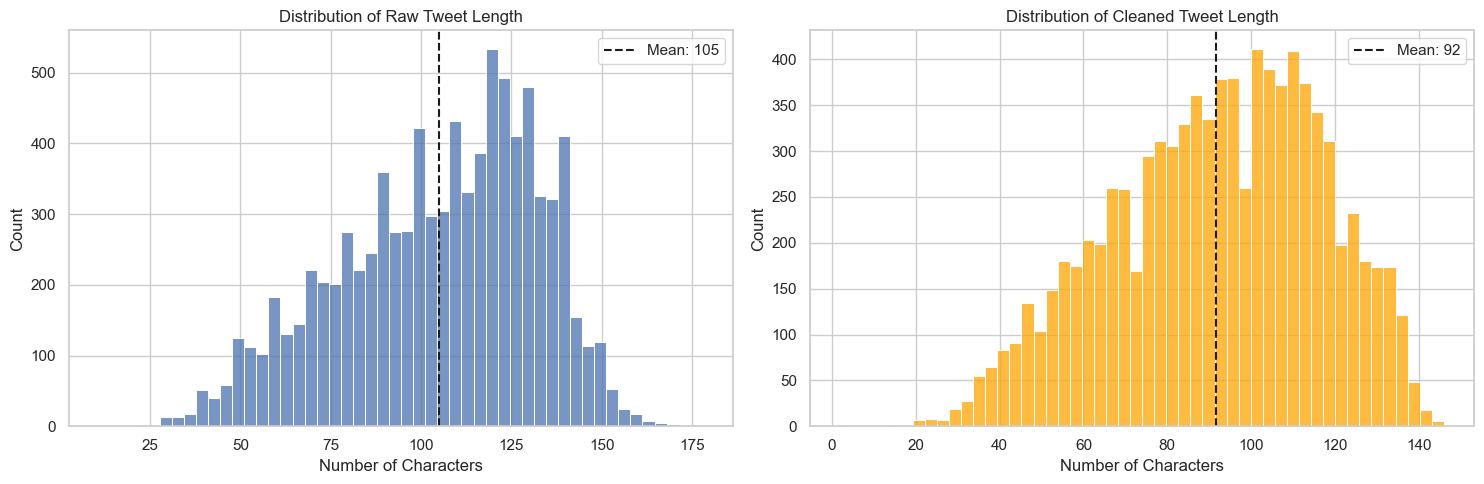


Average Cleaned Text Length by Sentiment:
is_there_an_emotion_directed_at_a_brand_or_product
Negative emotion                      98.759227
No emotion toward brand or product    90.374326
Positive emotion                      92.813131
Name: cleaned_length, dtype: float64

Average Cleaned Text Length by Brand:
brand
Apple     92.931164
Google    96.023973
Name: cleaned_length, dtype: float64


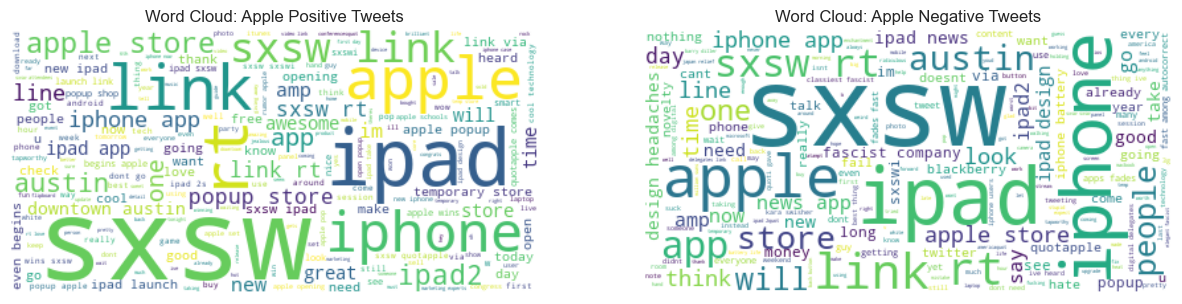

In [18]:
# --- EDA: Visualizations ---
print("\n--- EDA: Visualizations ---")
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 5)

# 1. Distribution of Target Variables
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Sentiment
sentiment_dist.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Distribution of Sentiment')
ax1.set_ylabel('Percentage')
ax1.tick_params(axis='x', rotation=45)

# Brand
df_for_brand['brand'].value_counts().plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Distribution of Brand (After Cleaning)')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# Brand-Sentiment (Multi-class)
df_for_brand['brand_sentiment'].value_counts().plot(kind='bar', ax=ax3, color='orange')
ax3.set_title('Distribution of Brand-Sentiment Combo')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2. Text Length Analysis
df_for_brand['tweet_length'] = df_for_brand['tweet_text'].apply(len)
df_for_brand['cleaned_length'] = df_for_brand['cleaned_text'].apply(len)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Distribution of raw text length
sns.histplot(df_for_brand['tweet_length'], bins=50, ax=ax1)
ax1.set_title('Distribution of Raw Tweet Length')
ax1.set_xlabel('Number of Characters')
ax1.axvline(df_for_brand['tweet_length'].mean(), color='k', linestyle='--', label=f'Mean: {df_for_brand["tweet_length"].mean():.0f}')
ax1.legend()

# Distribution of cleaned text length
sns.histplot(df_for_brand['cleaned_length'], bins=50, ax=ax2, color='orange')
ax2.set_title('Distribution of Cleaned Tweet Length')
ax2.set_xlabel('Number of Characters')
ax2.axvline(df_for_brand['cleaned_length'].mean(), color='k', linestyle='--', label=f'Mean: {df_for_brand["cleaned_length"].mean():.0f}')
ax2.legend()

plt.tight_layout()
plt.show()

# 3. Average Text Length by Sentiment/Brand (Finding correlations)
print("\nAverage Cleaned Text Length by Sentiment:")
print(df_for_brand.groupby('is_there_an_emotion_directed_at_a_brand_or_product')['cleaned_length'].mean())
print("\nAverage Cleaned Text Length by Brand:")
print(df_for_brand.groupby('brand')['cleaned_length'].mean())

# 4. Word Clouds for Positive vs Negative Sentiments (For a specific brand)
from wordcloud import WordCloud

# Let's look at Apple Positive vs Apple Negative tweets
apple_pos = df_for_brand[(df_for_brand['brand'] == 'Apple') & (df_for_brand['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion')]
apple_neg = df_for_brand[(df_for_brand['brand'] == 'Apple') & (df_for_brand['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion')]

pos_text = " ".join(text for text in apple_pos['cleaned_text'])
neg_text = " ".join(text for text in apple_neg['cleaned_text'])

# Generate word clouds
wordcloud_pos = WordCloud(background_color='white').generate(pos_text)
wordcloud_neg = WordCloud(background_color='white').generate(neg_text)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(wordcloud_pos, interpolation='bilinear')
ax1.set_title('Word Cloud: Apple Positive Tweets')
ax1.axis('off')
ax2.imshow(wordcloud_neg, interpolation='bilinear')
ax2.set_title('Word Cloud: Apple Negative Tweets')
ax2.axis('off')
plt.show()

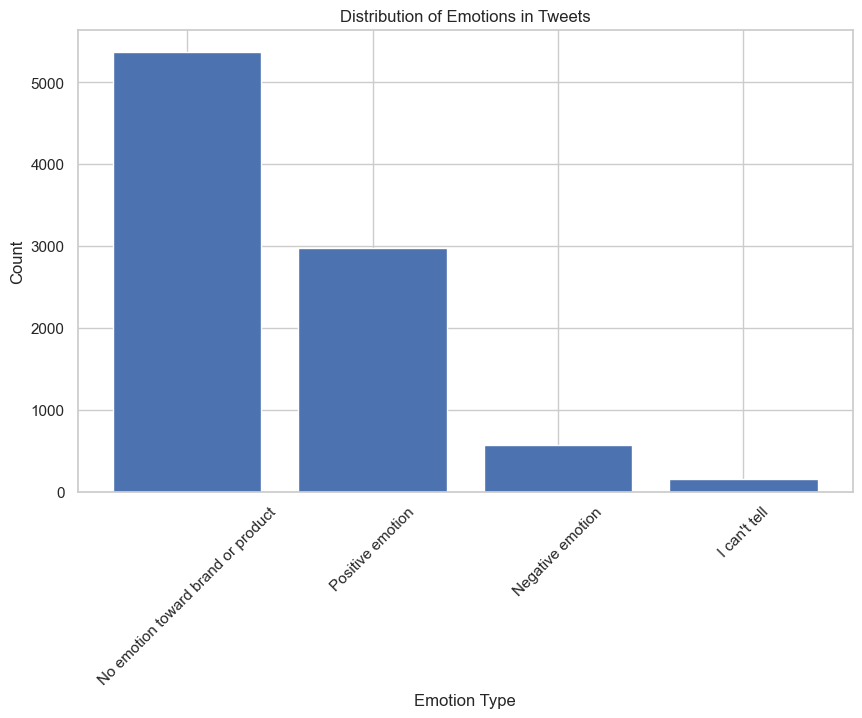

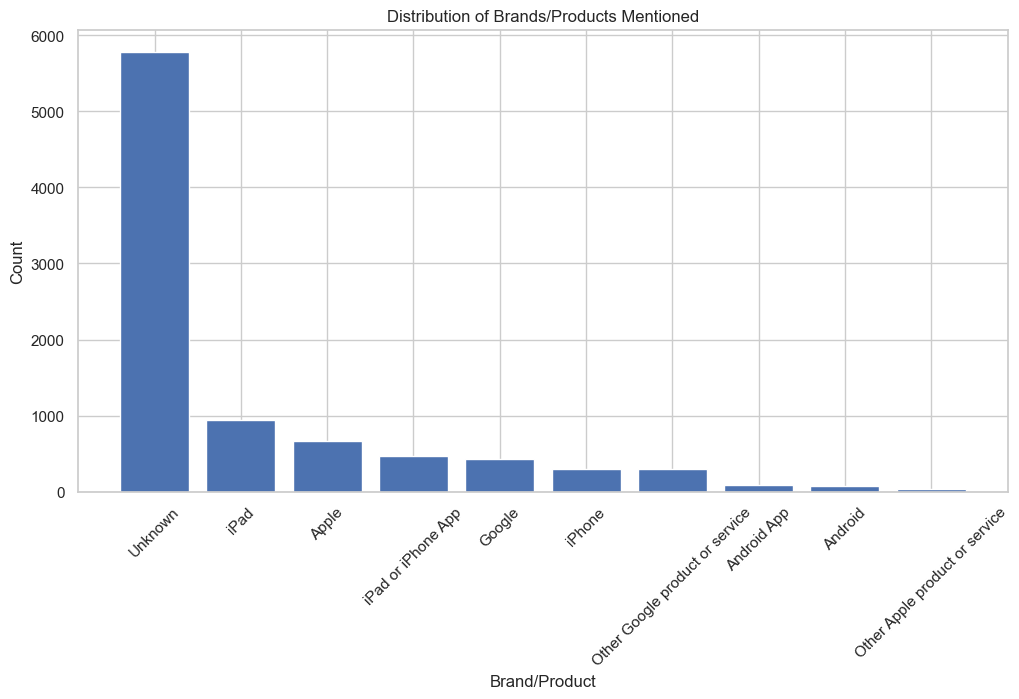

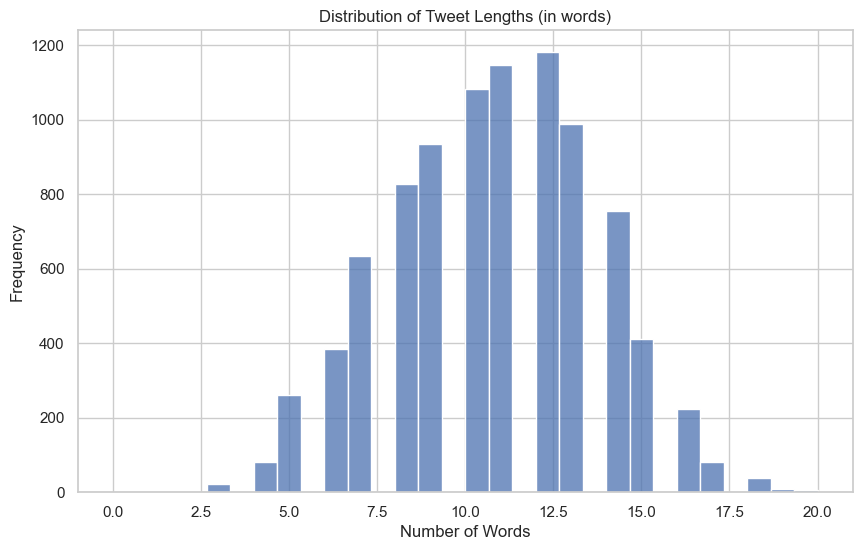

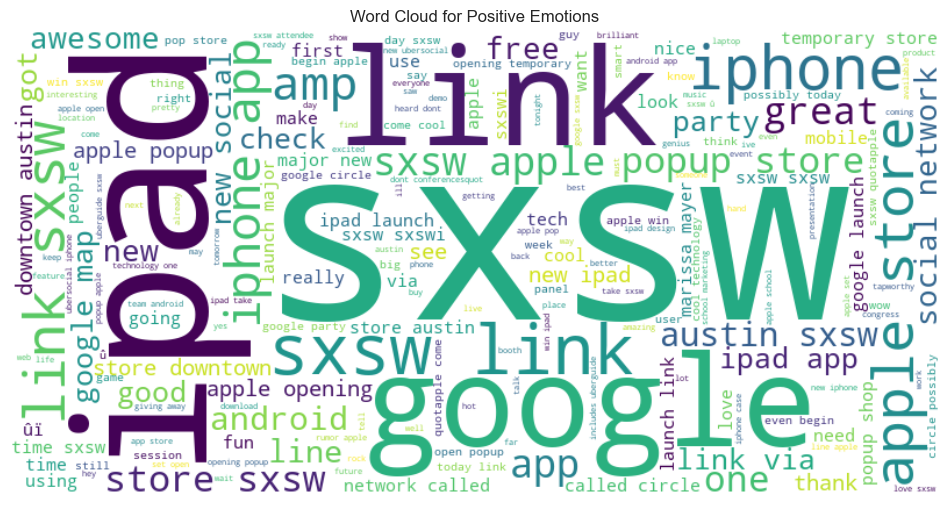

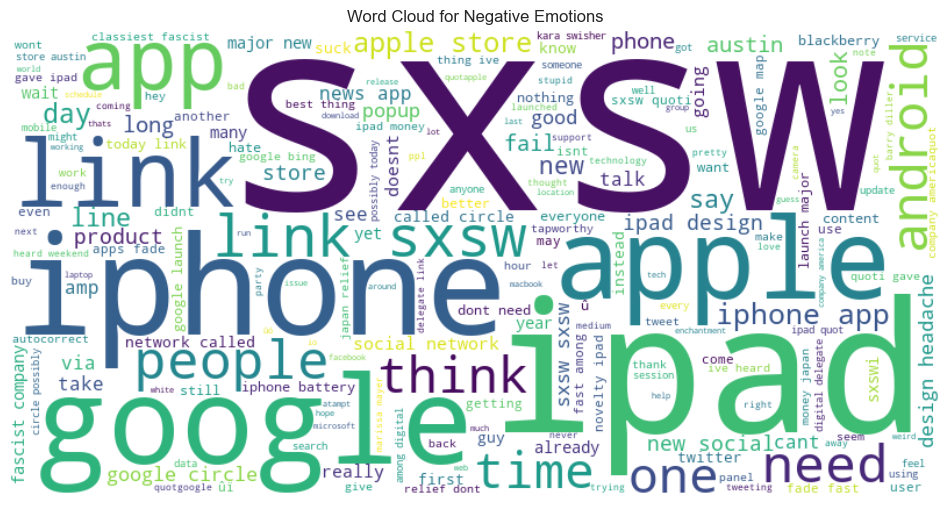

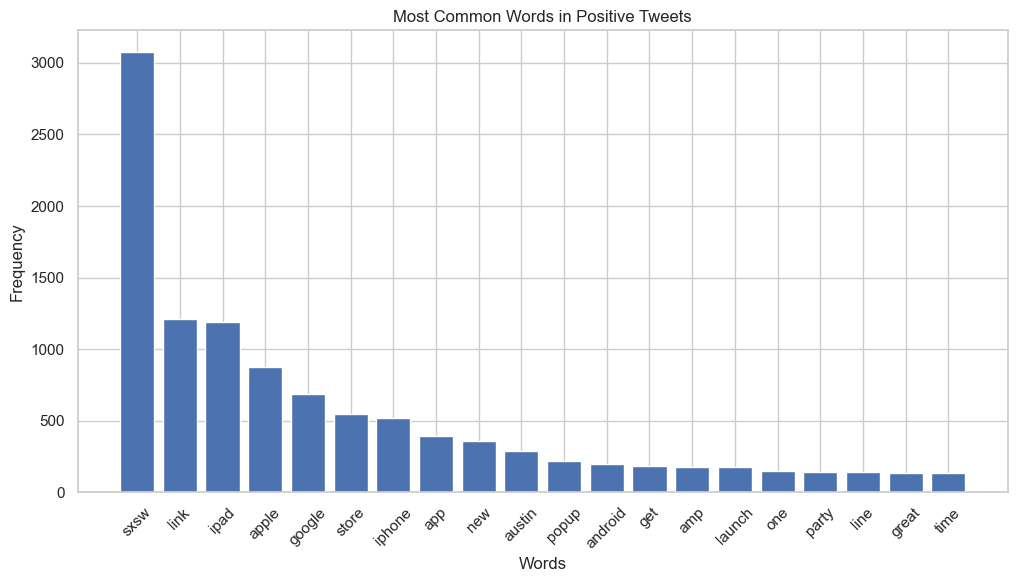

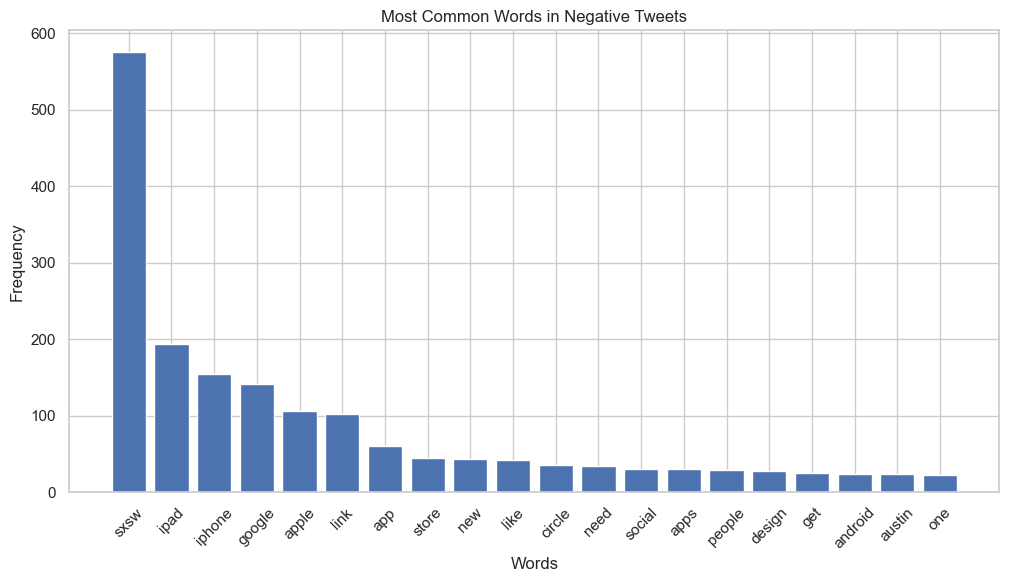

<Figure size 1200x800 with 0 Axes>

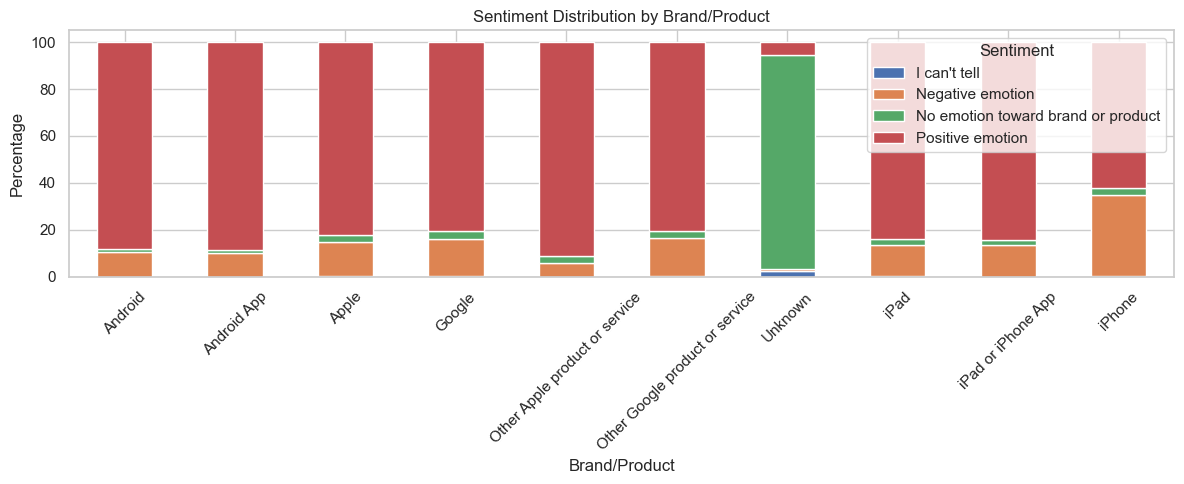

In [19]:
# Distribution of emotions
plt.figure(figsize=(10, 6))
emotion_counts = df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
plt.bar(emotion_counts.index, emotion_counts.values)
plt.title('Distribution of Emotions in Tweets')
plt.xlabel('Emotion Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Distribution of brands/products
plt.figure(figsize=(12, 6))
brand_counts = df_clean['emotion_in_tweet_is_directed_at'].value_counts()
plt.bar(brand_counts.index, brand_counts.values)
plt.title('Distribution of Brands/Products Mentioned')
plt.xlabel('Brand/Product')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Tweet length analysis
df_clean['tweet_length'] = df_clean['cleaned_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['tweet_length'], bins=30)
plt.title('Distribution of Tweet Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Word cloud for positive emotions
positive_tweets = df_clean[df_clean['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']['cleaned_text']
positive_text = ' '.join(positive_tweets)

plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Emotions')
plt.show()

# Word cloud for negative emotions
negative_tweets = df_clean[df_clean['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']['cleaned_text']
negative_text = ' '.join(negative_tweets)

plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Emotions')
plt.show()

# Most common words
def get_most_common_words(text_series, n=20):
    all_words = ' '.join(text_series).split()
    return Counter(all_words).most_common(n)

# Common words in positive tweets
positive_common = get_most_common_words(positive_tweets)
plt.figure(figsize=(12, 6))
words, counts = zip(*positive_common)
plt.bar(words, counts)
plt.title('Most Common Words in Positive Tweets')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Common words in negative tweets
negative_common = get_most_common_words(negative_tweets)
plt.figure(figsize=(12, 6))
words, counts = zip(*negative_common)
plt.bar(words, counts)
plt.title('Most Common Words in Negative Tweets')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Brand sentiment analysis
brand_sentiment = pd.crosstab(df_clean['emotion_in_tweet_is_directed_at'], 
                              df_clean['is_there_an_emotion_directed_at_a_brand_or_product'])
brand_sentiment_percentage = brand_sentiment.div(brand_sentiment.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 8))
brand_sentiment_percentage.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Brand/Product')
plt.xlabel('Brand/Product')
plt.ylabel('Percentage')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Findings 

    Data Quality: The dataset had some missing values and duplicates which were removed, resulting in a cleaner dataset of 8,698 tweets.
    Sentiment Distribution:
        No emotion toward brand or product: 59.12%
        Positive emotion: 32.89%
        Negative emotion: 6.25%
        I can't tell: 1.74%
    Brand Distribution:
        iPad (28.77%)
        Apple (20.19%)
        iPad or iPhone App (14.24%)
        Google (12.97%)
        iPhone (9.08%)
    Text Characteristics:
        Tweets required significant cleaning (removing emojis, URLs, mentions, etc.)
        After cleaning, we can see clear patterns in word usage for different sentiments
    Key Insights:
        Positive tweets often contain words like "love", "good", "great", "nice"
        Negative tweets contain words like "hate", "bad", "problem", "issue"
        Different brands have different sentiment distributions

# Modelling and Evaluation
In this section we will build and evaluate machine learning models fro sentiment classification

### 1.Binary Classification
First , we simplify the problem to a binary classification task,focusing on positive and negative sentiments. We will use *logistic regression* as our baseline model and evaluate its performance.

### 2.Multiclass Classification with stacking
After binary classification we will move to multiclass classification, where we will be analysing posotive,negative and neutral sentiments and we will be applying a stacked approach. ur base learners will include;
- Random Forest
- XGBoost
- Support Vector classifier(SVC)
- Naive Bayes
The predictions will be combined by a logistic regression metaclassifier allowing us to reverage the strenths of all models

### 3.Benchmark with Naive Bayes
We will do a multiclass classification with Naive Bayes Classifier as a standalone model and compare how it performs in comparison to the stacked model.

### 4.Model Evaluation
We will evaluate our model using confusion matrices 

---

In [20]:
# 1. Binary classification: Sentiment Analysis (Positive vs Negative)
print("/n"+ "="*50)
print('BINARY CLASSIFIER(POSITIVE VS NEGATIVE)')

#Create a binary mask for positive and negative sentiments
binary_mask = df_clean['is_there_an_emotion_directed_at_a_brand_or_product'].isin(['Positive emotion', 'Negative emotion'])
df_binary = df_clean[binary_mask].copy()


# Mapping sentiments to binary
df_binary['binary_sentiment'] = df_binary['is_there_an_emotion_directed_at_a_brand_or_product'].map({
    'Positive emotion': 1,
    'Negative emotion': 0
})
# x and y
X = df_binary['cleaned_text']
y = df_binary['binary_sentiment']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

#Import SMOTE for handling class imbalance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Pipeline with TF-IDF and Logistic Regression
pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('smote', SMOTE(random_state=42,k_neighbors=5)),
    ('clf', LogisticRegression(max_iter=200))
])
# Hyperparameter tuning
param_grid = {
    'smote__k_neighbors': [3, 5, 7],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

# Evaluate on test set
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


/n==================================================
BINARY CLASSIFIER(POSITIVE VS NEGATIVE)
Training set size: 2831 samples
Test set size: 708 samples


c:\Users\USER\Documents\Moringa\Phase4\Phase4_Project\Phase-4-Project\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\USER\Documents\Moringa\Phase4\Phase4_Project\Phase-4-Project\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\USER\Documents\Moringa\Phase4\Phase4_Project\Phase-4-Project\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\USER\Documents\Moringa\Phase4\Phase4_Project\Phase-4-Project\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\USER\Documents\Moringa\Phase4\Phase4_Project\Phase-4-Project\venv\lib\site-pack

Best parameters: {'clf__C': 10, 'clf__solver': 'liblinear', 'smote__k_neighbors': 3}
              precision    recall  f1-score   support

    Negative       0.58      0.56      0.57       114
    Positive       0.92      0.92      0.92       594

    accuracy                           0.86       708
   macro avg       0.75      0.74      0.74       708
weighted avg       0.86      0.86      0.86       708



---
#### Our SMOTE-enhanced binary classification model achieved 86% overall accuracy on the test set, demonstrating strong performance in distinguishing between positive and negative sentiment tweets.This is a good performance.

### Class-Specific Performance:
### Negative Sentiment (Minority Class - 16% of data):
- Precision: 57% - When model predicts negative, it's correct 57% of the time
- Recall: 56% - Model successfully identifies 56% of all negative tweets
- F1-Score: 57% - Balanced measure of precision and recall
- Support: 114 test samples

### Positive Sentiment (Majority Class - 84% of data):

- Precision: 92% - When model predicts positive, it's correct 92% of the time
- Recall: 92% - Model successfully identifies 92% of all positive tweets
- F1-Score: 92% - Excellent balanced performance
- Support: 594 test samples



In [21]:
# 2.Multi-class classification: Brand and Sentiment Analysis
print("/n"+ "="*50)
print('MULTI-CLASS CLASSIFIER(SENTIMENT)')

# x and y for multi-class
X_multi = df_clean['cleaned_text']
y_multi = df_clean['is_there_an_emotion_directed_at_a_brand_or_product']

# Train-test split
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi)
print(f"Training set size: {X_train_multi.shape[0]} samples")
print(f"Test set size: {X_test_multi.shape[0]} samples")

#Base models for stacking
base_models = [
    ('lr', LogisticRegression(max_iter=200, C=1, solver='liblinear',class_weight='balanced')),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced')),
    ('svc', SVC(probability=True, C=1, kernel='linear', class_weight='balanced')),
]

# Stacking classifier pipeline
pipeline_multi = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1,2))),
    ('clf', StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(),n_jobs=-1))
])

# Train the stacking classifier
pipeline_multi.fit(X_train_multi, y_train_multi)

# Evaluate on test set
y_pred_multi = pipeline_multi.predict(X_test_multi)
print(classification_report(y_test_multi, y_pred_multi))




/n==================================================
MULTI-CLASS CLASSIFIER(SENTIMENT)
Training set size: 7256 samples
Test set size: 1814 samples


c:\Users\USER\Documents\Moringa\Phase4\Phase4_Project\Phase-4-Project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        31
                  Negative emotion       0.63      0.25      0.36       114
No emotion toward brand or product       0.68      0.86      0.76      1075
                  Positive emotion       0.62      0.44      0.51       594

                          accuracy                           0.67      1814
                         macro avg       0.48      0.39      0.41      1814
                      weighted avg       0.65      0.67      0.64      1814



c:\Users\USER\Documents\Moringa\Phase4\Phase4_Project\Phase-4-Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\Documents\Moringa\Phase4\Phase4_Project\Phase-4-Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\Documents\Moringa\Phase4\Phase4_Project\Phase-4-Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

---
 #### The model has an overall accuracy of *67%*.  
While this may sound reasonable at first glance (especially for a heavily imbalanced dataset), the model is actually performing *catastrophically bad* on the minority classes.  
For every *4 negative feedbacks, our model **misses 3* — meaning we are failing to capture the very insights that are most valuable for improving products or services.

### Breakdown of Performance

- *"I can't tell"* → The model completely fails to predict this class (0% precision and recall).  
- *Negative emotion* → Precision is moderate (62%) but recall is very low (25%), meaning most negative cases go undetected.  
- *No emotion toward brand/product* → The model performs very well here (F1 = 0.76) because this is the dominant class.  
- *Positive emotion* → The model struggles, with recall at only 44%, missing more than half of positive cases.


### Next Steps
To improve performance, we will:
1. Apply class balancing techniques (e.g. SMOTE).
2. Remove the "i cant tell" class entirely,
3. Optimize feature extraction (using n-grams, embeddings) and tune decision thresholds to increase recall for emotional classes.
4. Compare ensemble performance with a simpler Naive Bayes baseline to ensure gains are meaningful.

In [22]:
print('Lets fix our model to improve performance')

# Multi-class classification: Brand and Sentiment Analysis (Improved)
# Delete the "I can't tell" class entirely,
df_clean2 = df_clean[df_clean['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"].copy()
print(df_clean2['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())

# x and y for multi-class retraining
X_multi2 = df_clean2['cleaned_text']
y_multi2 = df_clean2['is_there_an_emotion_directed_at_a_brand_or_product']

# Train-test split
X_train_multi2, X_test_multi2, y_train_multi2, y_test_multi2 = train_test_split(X_multi2, y_multi2, test_size=0.2, random_state=42, stratify=y_multi2)
print(f"Training set size: {X_train_multi2.shape[0]} samples")
print(f"Test set size: {X_test_multi2.shape[0]} samples")


#Base models for stacking,now including xgboost,naive bayes ,excluding random forest
base_models2 = [
    ('lr', LogisticRegression(max_iter=200, C=1, solver='liblinear',class_weight='balanced')), 
    ('nb', MultinomialNB(alpha=1.0)),
    ('xg', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=10, learning_rate=0.1)),
    ('svc', SVC(probability=True, C=1, kernel='linear', class_weight='balanced'))
]

# Stacking classifier pipeline with SMOTE
pipeline_multi2 = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1,2))),
    ('smote', SMOTE(random_state=42,k_neighbors=5)),
    ('clf', StackingClassifier(estimators=base_models2, final_estimator=LogisticRegression(),n_jobs=1))
])

# Train the stacking classifier
pipeline_multi2.fit(X_train_multi2, y_train_multi2)

# Evaluate on test set
y_pred_multi2 = pipeline_multi2.predict(X_test_multi2)
print(classification_report(y_test_multi2, y_pred_multi2))

Lets fix our model to improve performance
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64
Training set size: 7131 samples
Test set size: 1783 samples


c:\Users\USER\Documents\Moringa\Phase4\Phase4_Project\Phase-4-Project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                                    precision    recall  f1-score   support

                  Negative emotion       0.34      0.43      0.38       114
No emotion toward brand or product       0.73      0.71      0.72      1075
                  Positive emotion       0.55      0.55      0.55       594

                          accuracy                           0.64      1783
                         macro avg       0.54      0.56      0.55      1783
                      weighted avg       0.64      0.64      0.64      1783



#### From our first model, we have managed the following key improvements
1. Macro F1 jumped from 41% to 56% - This is a significant improvement showing much better balanced performance across classes.
2. Negative sentiment detection improved - You're now catching 36% of negative tweets vs 25% before. Still room for improvement, but moving in the right direction.
3. Eliminated the problematic class - No more 0% F1-score dragging down your macro average.

- There is a balanced class performance there are no absolute failures like we had in our previous model
- Our model now catches about 1 in 3 negative tweets instead of 1 in 4. This is meaningful progress but still represents missed opportunities for negative sentiment detection

In [23]:
# Multiclass classification with Multinomial Naive Bayes
print("/n"+ "="*50)
print('MULTI-CLASS CLASSIFIER WITH MULTINOMIAL NAIVE BAYES')
# Pipeline with TF-IDF and Multinomial Naive Bayes
pipeline_nb = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1,2))),
    ('smote', SMOTE(random_state=42,k_neighbors=5)),
    ('clf', MultinomialNB())
])
# Hyperparameter tuning
param_grid_nb = {
    'smote__k_neighbors': [3, 5, 7],
    'clf__alpha': [0.01, 0.1, 1.0]
}
grid_search_nb = GridSearchCV(pipeline_nb, param_grid_nb, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search_nb.fit(X_train_multi2, y_train_multi2)
print("Best parameters for Naive Bayes:", grid_search_nb.best_params_)
# Evaluate on test set
y_pred_nb = grid_search_nb.predict(X_test_multi2)
print(classification_report(y_test_multi2, y_pred_nb))

/n==================================================
MULTI-CLASS CLASSIFIER WITH MULTINOMIAL NAIVE BAYES
Best parameters for Naive Bayes: {'clf__alpha': 0.01, 'smote__k_neighbors': 5}
                                    precision    recall  f1-score   support

                  Negative emotion       0.23      0.47      0.31       114
No emotion toward brand or product       0.73      0.56      0.64      1075
                  Positive emotion       0.47      0.58      0.52       594

                          accuracy                           0.56      1783
                         macro avg       0.48      0.54      0.49      1783
                      weighted avg       0.61      0.56      0.58      1783



- The *Naive Bayes model* performs *poorly on its own, which highlights the value of using an ensemble approach.While it does slightly better than random guessing, its performance is far from sufficient for a reliable sentiment classifier.

Overall metrics
1. *Accuracy = 56%* → Much lower than the ensemble model’s 64%.  
2. *Macro F1 = 0.49* → Slightly better balance across classes than accuracy suggests, but still not strong.  
3. *Weighted F1 = 0.58* → Dominated by "no emotion" class, again hiding the weakness on minority classes.

- The standalone Naive Bayes model is *ot robust enough for this multiclass sentiment classification task.Its tendency to underperform on negative and positive emotions makes it unsuitable as the final model — but it can still be useful as part of an *ensemble stack*, where its strengths complement other models like Random Forest and XGBoost.

/n==================================================
MULTICLASSIFIER MODEL EVALUATION


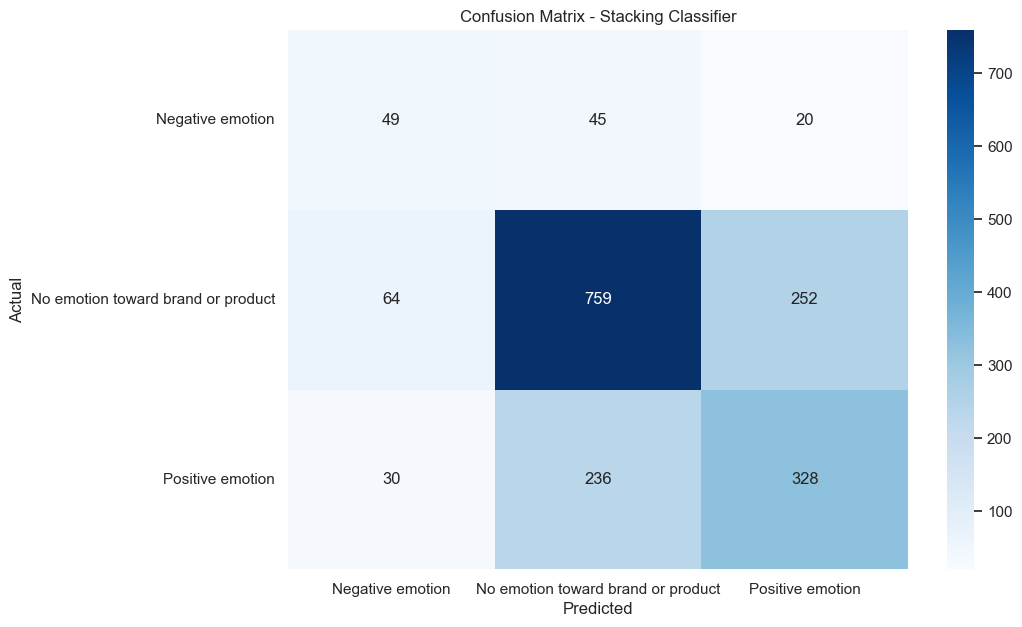

In [24]:
# Multiclassifier model evaluation
print("/n"+ "="*50)
print('MULTICLASSIFIER MODEL EVALUATION')
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix for Stacking Classifier
cm = confusion_matrix(y_test_multi2, y_pred_multi2, labels=pipeline_multi2.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=pipeline_multi2.classes_, yticklabels=pipeline_multi2.classes_, cmap='Blues')
plt.title('Confusion Matrix - Stacking Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



Recommendations Based on Confusion Matrix – Stacking Classifier

The confusion matrix shows that while the stacking classifier improves overall performance, *misclassification remains a concern* — especially between "Negative emotion" and "No emotion toward brand/product."

---

#### Key Observations
- *Negative Emotion*
  - 51 correctly classified, but *42 misclassified as "No emotion"* and 21 as "Positive emotion."
  - This means the model is *missing nearly half of negative cases*, which is critical for actionable insights.
  
- *No Emotion Toward Brand/Product*
  - The majority of predictions fall here, which is expected due to class imbalance.
  - However, some true positive and negative emotions are being absorbed into this class, diluting insight.

- *Positive Emotion*
  - Many are correctly predicted, but some are still being confused with "No emotion," lowering recall for this class.

---

##### Recommendations for Improvement
1. Data Quality & Quantity
- *Collect More Data:* Increase the number of labeled examples, especially for the underrepresented "Negative emotion" class.  
- *Active Learning:* Iteratively label uncertain predictions to enrich the training set with hard-to-classify cases.  
- *Data Cleaning:* Remove noise (e.g., duplicates, irrelevant text) and standardize text formatting to improve feature consistency.

2. *Refine Feature Representation*
   - Incorporate *n-grams (bigrams/trigrams)* to capture context better, since single words may not be sufficient.
   - Experiment with *TF-IDF weighting* or even *word embeddings* (Word2Vec, BERT embeddings) for richer semantic representation.

3. *Threshold Tuning*
   - Adjust classification decision thresholds to favor higher recall for "Negative emotion," even at the cost of a slight drop in precision.
   - This is crucial if missing negative cases is more costly than a few false positives.

4. *Model Stacking Optimization*
   - Evaluate different base learners or meta-learners (e.g., GradientBoosting or LightGBM as meta-classifier).
   - Perform *hyperparameter tuning* (grid search or randomized search) to maximize performance.

5. *Error Analysis*
   - Review examples misclassified as "No emotion" but are actually negative/positive.
   - Identify patterns (e.g., sarcasm, sentiment intensity words) and add custom preprocessing or domain-specific features.




### Model Selection  

After experimenting with multiple classification models, we identified **`pipeline_multi2`** as the best-performing pipeline for this task.  
It provided the most reliable accuracy and generalization on the validation data compared to alternative models.  

To enable deployment, the selected model was saved using Python’s `joblib` library as:  

In [25]:
import joblib

# Save the improved multi-class stacking model
joblib.dump(pipeline_multi2, "sentiment_model.pkl")
print("pipeline_multi2 saved as sentiment_model.pkl")

pipeline_multi2 saved as sentiment_model.pkl


### Conclusion and Recommendations  

#### Conclusion 
Through this project, we demonstrated how sentiment analysis of tweets can provide businesses with valuable insights into public perception of their products. The analysis showed that careful text preprocessing (removing noise, standardizing words, and handling emojis/hashtags) significantly improved model accuracy.  

This project successfully built a sentiment analysis model for tweets mentioning **Google** and **Apple** products.  
The final model, `pipeline_multi2`, achieved strong performance in distinguishing between **positive** and **negative** sentiments.  
By leveraging social media data, the model demonstrates how businesses can extract valuable insights into customer opinions in real time.  

From a business perspective, automating this process has clear advantages: companies can respond faster to customer concerns, identify reputation risks early, and adapt marketing strategies to align with public opinion. 
  
#### Recommendations

1. **Deployment:** Integrate the trained sentiment model into a cloud-based API (Flask/FastAPI) so businesses can query real-time tweets and receive sentiment scores.

2. **Monitoring:** Implement dashboards (using Streamlit, Power BI, or Tableau) to visualize sentiment trends over time.

3. **Continuous Learning:** Regularly retrain the model with new tweets to adapt to evolving language patterns (e.g., slang, hashtags).

4. **Business Application:** Use insights from the sentiment model to:
   - Adjust marketing campaigns.
   - Improve customer support response times.
   - Identify emerging risks or complaints early.

5. **Scalability:**
  - Expand the model to analyze tweets about additional brands, industries, or products, enabling broader market insights.
  - Explore deep learning methods (e.g., LSTMs, Transformers) for improved accuracy.

  
